#EXEC

##SPEA2

###Imports

In [1]:
!pip install pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210079 sha256=202b93f4563ef2d9dd715ccfb548de473bdafbf3dfb8387d5ace1b3d2117dffa
  Stored in directory: /root/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully built grapheme


In [2]:
from pymoo.core.problem import Problem
from pymoo.core.population import Population
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.util import plotting
from pymoo.core.evaluator import Evaluator
from pymoo.core.mutation import Mutation
from pymoo.core.crossover import Crossover
from pymoo.core.selection import Selection
from pymoo.core.variable import Real, get
from pymoo.operators.selection.tournament import compare
from pymoo.util.misc import random_permuations
import numpy as np
import math
from pymoo.operators.mutation.gauss import mut_gauss
from pymoo.core.mating import Mating
from pymoo.algorithms.base.genetic import GeneticAlgorithm
from pymoo.core.survival import Survival
from pymoo.docs import parse_doc_string
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.crossover.spx import SPX
from pymoo.operators.mutation.gauss import GaussianMutation
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.selection.tournament import compare, TournamentSelection
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.util.display.single import SingleObjectiveOutput
from pymoo.core.algorithm import Algorithm
from pymoo.core.duplicate import DefaultDuplicateElimination, NoDuplicateElimination
from pymoo.core.initialization import Initialization
from pymoo.core.mating import Mating
from pymoo.core.population import Population
from pymoo.core.repair import NoRepair
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.problems import get_problem
from pymoo.problems.single import Rastrigin
from pymoo.optimize import minimize
from pymoo.operators.crossover.pcx import ParentCentricCrossover
from pymoo.operators.mutation.rm import ChoiceRandomMutation
import matplotlib
from matplotlib import pyplot as plt
import random
from pymoo.termination import get_termination
from pymoo.algorithms.base.genetic import GeneticAlgorithm
from pymoo.algorithms.moo.nsga3 import HyperplaneNormalization
from pymoo.core.survival import Survival
from pymoo.docs import parse_doc_string
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.selection.tournament import TournamentSelection, compare
from pymoo.termination.default import DefaultMultiObjectiveTermination
from pymoo.util.display.multi import MultiObjectiveOutput
from pymoo.util.dominator import Dominator
from pymoo.util.misc import vectorized_cdist
from pymoo.algorithms.moo.spea2 import SPEA2Survival
from pymoo.algorithms.moo.spea2 import spea_binary_tournament
from pymoo.util.dominator import Dominator
from pymoo.util.misc import vectorized_cdist
from itertools import chain
from pymoo.operators.crossover.pntx import SinglePointCrossover
from pymoo.operators.repair.rounding import RoundingRepair

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Data_artigo/Data_ZDT3

[Errno 2] No such file or directory: '/content/drive/MyDrive/Data_artigo/Data_ZDT3'
/content


##In-Vitro(SPEA2)

In [5]:
from pymoo.operators.mutation.pm import PM
import numpy as np


class InVitroFertilizationSPEA2:

  def __init__(self, numIndv, taxa_exec, mutEAR = PM(prob=1, prob_var = 1), EARN = False, prob_mae = None, prob_var = None, **kwargs):
        super().__init__(**kwargs)
        self.mutEAR = mutEAR
        self.numIndv = numIndv
        self.ivf_n_evals = 0
        self.ivf_n_gens = 0
        self.n_evals_possiveis = None
        self.taxa_exec = taxa_exec
        self.EARN = EARN
        self.prob_mae = prob_mae
        self.prob_var = prob_var

  def do(self, pop, problem, algorithm, n_evals_possiveis = 0, obj_foco = None):
          self.n_evals_possiveis = n_evals_possiveis

          if obj_foco is None:
            obj_foco = np.random.randint(problem.n_obj)

          if(self.n_evals_possiveis <= 0):
            F = pop.get("SPEA_F")
            val = np.argmin(F)
            #print("Retornado: ",pop[val].get("F"), "\n\n")
            return pop[val]

          self.ivf_n_gens += 1

          Pai, Maes = self.Coleta(pop, problem = problem, n_select = self.numIndv)
          #print("Recebido: ",pop[Pai].get("F"))

          if(self.EARN):
            maesEAR = self.EAR_N(pop, problem, Maes)
          else:
            if(self.prob_mae is None):
              self.prob_mae = 0.5
            if(self.prob_var is None):
              self.prob_var = 0.5
            maesEAR = self.EAR_base(pop, problem, Maes)

          #off1, off2 = self.Recombinacao(pop.get("X")[Pai], maesEAR.get("X"),problem)

          off1, off2 = self.RecombinacaoPymoo(pop[Pai], maesEAR, problem)

          melhor, superB = self.Aval_Super(problem, off1, off2, algorithm)

          bool_melhor, Pai_Corrente = self.ComparaSB(pop[Pai], superB[melhor], obj_foco)

          #print(Pai_Corrente.get("X"), Pai_Corrente.get("F"))
          if(bool_melhor):
            pop[Pai] = Pai_Corrente

            return Population.merge(superB, self.do(pop, problem, algorithm, self.n_evals_possiveis, obj_foco))

          else:
            #print("Retornado: ",Pai_Corrente.get("F"), "\n\n")
            pop[Pai] = Pai_Corrente
            return superB



  def Coleta(self, pop, problem, n_select = None, **kwargs):

          if n_select is None or n_select > len(pop)-1:
            n_select = len(pop)-1

          if n_select <= 1:
            n_select = problem.n_obj

          k = int(np.sqrt(len(pop)))
          if k >= len(pop):
              k = len(pop) - 1

          maes = list(chain(range(problem.n_obj) , range(problem.n_obj+1, n_select)))
          #print(maes)

          pai = problem.n_obj


          return pai,maes


  def EAR_base(self, pop, problem, maes, **kwargs):
          X = pop.get("X").astype(float)

          qtd_elementos = int(len(maes) * self.prob_mae)

          mutm = maes[-qtd_elementos:]

          Xp = self.mutEAR._do(problem, X)

          prob = np.ones(problem.n_var) * self.prob_var
          M = np.random.random(Xp.shape) < prob[None, :]

          X[mutm] = np.where(M, Xp, X)[mutm]

          maesEAR = Population.new("X", X[mutm])

          return maesEAR

  def EAR_PA(self, pop, problem, maes, **kwargs):
          X = pop.get("X").astype(float)

          pos = math.ceil(len(maes)/2)
          mutm = random.sample(maes, pos)

          Xp = self.mutEAR._do(problem, X)

          maesEAR = Population.new("X", Xp[mutm])

          return maesEAR


  def EAR_T(self, pop, problem, maes, **kwargs):
          X = pop.get("X").astype(float)

          pos = math.ceil(len(maes)/2)
          mutm = maes[pos:]

          Xp = self.mutEAR._do(problem, X)

          maesEAR = Population.new("X", Xp[mutm])

          return maesEAR


  def EAR_N(self, pop, problem, maes, **kwargs):

          pos = math.ceil(len(maes)/2)
          mutm = maes[pos:]

          new_pop_size = len(mutm)
          Xp = np.random.uniform(low=problem.xl, high=problem.xu, size=(new_pop_size, problem.n_var))

          maesEAR = Population.new("X", Xp)

          return maesEAR


  def Recombinacao(self, pai, maes, problem, **kwargs):
          #print(pai)
          corte = np.random.randint(low = 1, high = problem.n_var)
          #print(maes)
          Xf = maes.copy()
          Xs = maes.copy()
          #print(Xf)
          for aux in Xf:
            aux[:corte] = pai[:corte]

          for aux in Xs:
            aux[corte:] = pai[corte:]

          off1 = Population.new("X", Xf)
          off2 = Population.new("X", Xs)
          #print(maes)

          #print(off1.get("X"), off2.get("X"))
          return off1, off2


  def RecombinacaoPymoo(self, pai, maes, problem, **kwargs):

          parents1 = []
          parents2 = []

          for b in maes:
            parents1.append([pai, b])

          for b in maes:
            parents2.append([b, pai])

          off1 = SinglePointCrossover(prob=1.0, repair=RoundingRepair(), vtype=float).do(problem, parents1)
          off2 = SinglePointCrossover(prob=1.0, repair=RoundingRepair(), vtype=float).do(problem, parents2)

          #print(off1.get("X"))
          #print(off2.get("X"))

          return off1, off2

  def RecombinacaoPymooUniforme(self, pai, maes, problem, **kwargs):

          parents1 = []
          parents2 = []

          for b in maes:
            parents1.append([pai, b])

          for b in maes:
            parents2.append([b, pai])

          off1 = SinglePointCrossover(prob=1.0, repair=RoundingRepair(), vtype=float).do(problem, parents1)
          off2 = SinglePointCrossover(prob=1.0, repair=RoundingRepair(), vtype=float).do(problem, parents2)

          #print(off1.get("X"))
          #print(off2.get("X"))

          return off1, off2

  def Aval_Super(self, problem, grupo1, grupo2, algorithm,**kwargs):

          off = Population.merge(grupo1,grupo2)

          if(self.n_evals_possiveis - len(off) < 0):
            perm = np.random.permutation(len(off))[:self.n_evals_possiveis]
            X = off[perm].get("X")
            superB = Population.new("X", X)

          else:
            superB = off


          algorithm.evaluator.eval(problem, superB)

          self.ivf_n_evals += len(superB)
          self.n_evals_possiveis -= len(superB)
          #print(self.ivf_n_evals)

          F = superB.get("F").astype(float, copy=False)

          M = Dominator().calc_domination_matrix(F)

          S = (M == 1).sum(axis=0)

          R = ((M == -1) * S).sum(axis=1)

          k = int(np.sqrt(len(superB)))
          if k >= len(superB):
              k = len(superB) - 1

          dists = vectorized_cdist(F, F, fill_diag_with_inf=True)

          sdists = np.sort(dists, axis=1)

          D = 1 / (sdists[:, k] + 2)

          SPEA_F = R + D

          superB.set(SPEA_F=SPEA_F, SPEA_R=R, SPEA_D=D)

          SPEA_F = superB.get("SPEA_F")

          val = np.argmin(SPEA_F)

          #print(superB.get("SPEA_F"))
          return val, superB

  def ComparaSB(self, pai, superB, obj_foco, **kwargs):
          FsB = superB.get("F").astype(float, copy=False)
          Fp = pai.get("F").astype(float, copy=False)

          if(FsB[obj_foco] < Fp[obj_foco]):
            #print(superB.get("F"),">", pai.get("F"))
            return True, superB

          #print(pai.get("F"), " > ", superB.get("F")[i])
          else:
            return False, pai

  def conta_n_evals_invit(self):
      return self.ivf_n_evals

  def conta_n_gens_invit(self):
      return self.ivf_n_gens


In [6]:
#
misc = [6,6,3,4,5]
misc = misc[2:]
print(misc)

[3, 4, 5]


###IVFGeneticAlgorithm

In [7]:
class IVFGeneticAlgorithm(Algorithm):

    def __init__(self,
                 pop_size=None,
                 sampling=None,
                 selection=None,
                 crossover=None,
                 mutation=None,
                 survival=None,
                 n_offsprings=None,
                 IVF = None,
                 eliminate_duplicates=DefaultDuplicateElimination(),
                 repair=None,
                 mating=None,
                 advance_after_initial_infill=False,
                 **kwargs
                 ):

        super().__init__(**kwargs)

        # the population size used
        self.pop_size = pop_size

        # whether the algorithm should be advanced after initialization of not
        self.advance_after_initial_infill = advance_after_initial_infill

        # the survival for the genetic algorithm
        self.survival = survival

        # number of offsprings to generate through recombination
        self.n_offsprings = n_offsprings

        # if the number of offspring is not set - equal to population size
        if self.n_offsprings is None:
            self.n_offsprings = pop_size

        # Setando a condição do InVitro ativa
        self.IVF = IVF

        # set the duplicate detection class - a boolean value chooses the default duplicate detection
        if isinstance(eliminate_duplicates, bool):
            if eliminate_duplicates:
                self.eliminate_duplicates = DefaultDuplicateElimination()
            else:
                self.eliminate_duplicates = NoDuplicateElimination()
        else:
            self.eliminate_duplicates = eliminate_duplicates

        # simply set the no repair object if it is None
        self.repair = repair if repair is not None else NoRepair()

        self.initialization = Initialization(sampling,
                                             repair=self.repair,
                                             eliminate_duplicates=self.eliminate_duplicates)

        if mating is None:
            mating = Mating(selection,
                            crossover,
                            mutation,
                            repair=self.repair,
                            eliminate_duplicates=self.eliminate_duplicates,
                            n_max_iterations=100)
        self.mating = mating

        # other run specific data updated whenever solve is called - to share them in all algorithms
        self.n_gen = None
        self.pop = None
        self.off = None
        self.ivf_n_evals = 0
        self.ivf_n_gens = 0

    def _initialize_infill(self):
        pop = self.initialization.do(self.problem, self.pop_size, algorithm=self)
        return pop

    def _initialize_advance(self, infills=None, **kwargs):
        if self.advance_after_initial_infill:
            self.pop = self.survival.do(self.problem, infills, n_survive=len(infills), algorithm=self, **kwargs)

    def _infill(self):
        avals_gastos = 0
        off1 = None
        #do the IVF mating using the current population
        if self.IVF is not None:
          if self.IVF.taxa_exec > random.random():
              #print(self.IVF.ciclos)
              off1 = self.IVF.do(self.pop, self.problem, self, n_evals_possiveis = math.floor(len(self.pop)))
              #print(off1.get("X"), "\n", len(off1),"\n===================================\n")
              avals_gastos = self.ivf_n_evals
              self.ivf_n_evals = self.IVF.conta_n_evals_invit()
              avals_gastos = self.ivf_n_evals - avals_gastos
              #print(avals_gastos)
              #print(self.pop_size, "\n\n")
              #print(avals_gastos)
              #print("Menor fitness da população",pop.get("F")[np.argmin(pop.get("F"))])
              #print("Menor fitness retornado",aux.get("F")[np.argmin(aux.get("F"))],"\n\n")
              #print(aux.get("X"),"\n\n")
              #print(self.IVF.conta_n_evals_invit())

              self.ivf_n_gens = self.IVF.conta_n_gens_invit()
              #print(self.conta_n_evals_invit())
              #print(self.conta_n_gens_invit())

        # do the mating using the current population
        off2 = self.mating.do(self.problem, self.pop, (self.n_offsprings - avals_gastos), algorithm=self)


        # if the mating could not generate any new offspring (duplicate elimination might make that happen)
        if len(off2) == 0 and avals_gastos < self.pop_size:
            self.termination.force_termination = True
            return

        # if not the desired number of offspring could be created
        elif len(off2) + avals_gastos < self.n_offsprings:
            if self.verbose:
                print("WARNING: Mating could not produce the required number of (unique) offsprings!")

        off = Population.merge(off1, off2)

        return off

    def _advance(self, infills=None, **kwargs):

        # the current population
        pop = self.pop

        # merge the offsprings with the current population
        if infills is not None:
            pop = Population.merge(self.pop, infills)

        # execute the survival to find the fittest solutions
        self.pop = self.survival.do(self.problem, pop, n_survive=self.pop_size, algorithm=self, **kwargs)

    def conta_n_evals_invit(self):
        return self.ivf_n_evals

    def conta_n_gens_invit(self):
        return self.ivf_n_gens

###IVFSPEA2

In [8]:
class IVFSPEA2(IVFGeneticAlgorithm):

    def __init__(self,
                 pop_size=100,
                 sampling=FloatRandomSampling(),
                 selection=TournamentSelection(spea_binary_tournament),
                 crossover=SBX(),
                 mutation=PM(),
                 survival=SPEA2Survival(normalize=True),
                 IVF = None,
                 eliminate_duplicates=True,
                 n_offsprings=None,
                 output=MultiObjectiveOutput(),
                 **kwargs):
        """
        SPEA2 - Strength Pareto EA 2
        Parameters
        ----------
        pop_size : {pop_size}
        sampling : {sampling}
        selection : {selection}
        crossover : {crossover}
        mutation : {mutation}
        eliminate_duplicates : {eliminate_duplicates}
        n_offsprings : {n_offsprings}
        """

        super().__init__(pop_size=pop_size,
                         sampling=sampling,
                         selection=selection,
                         crossover=crossover,
                         mutation=mutation,
                         survival=survival,
                         IVF = IVF,
                         eliminate_duplicates=eliminate_duplicates,
                         n_offsprings=n_offsprings,
                         output=output,
                         advance_after_initial_infill=True,
                         **kwargs)
        self.termination = DefaultMultiObjectiveTermination()


parse_doc_string(IVFSPEA2.__init__)

##Pratica

In [ ]:
from scipy.stats import ranksums
from pymoo.termination import get_termination
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.colors as colors
from pymoo.indicators.igd import IGD
import seaborn as sns
from pymoo.algorithms.moo.spea2 import SPEA2
from matplotlib.colors import ListedColormap
import pandas as pd
import os
from scipy.stats import wilcoxon
import datetime

def exec_algoritm_igd(problem, taxaExec, nIndv, prob_m, prob_v):
  if(prob_m == 0.5 and prob_v == -1):
    if os.path.isfile(f'/content/drive/MyDrive/Data_artigo/Data_20000/Data_{problem.name()}_Seed/DATA_{taxaExec}_{nIndv}_EARN.csv'):
      df = pd.read_csv(f'/content/drive/MyDrive/Data_artigo/Data_20000/Data_{problem.name()}_Seed/DATA_{taxaExec}_{nIndv}_EARN.csv', index_col=0)
      nome = f'DATA_{taxaExec}_{nIndv}_EARN.csv'
    else:
      df = pd.DataFrame( columns = ['IGD','RUN', 'r', 'c', 'm', 'v','EAR', 'ALGORITHM', 'PROBLEM', 'T_POP', 'N_GENS', 'TOT_AVALS', 'IVF_AVALS'])
      nome = f'DATA_{taxaExec}_{nIndv}_EARN.csv'
  else:
    if os.path.isfile(f'/content/drive/MyDrive/Data_artigo/Data_20000/Data_{problem.name()}_Seed/DATA_{taxaExec}_{nIndv}_{prob_m}_{prob_v}_Base.csv'):
      df = pd.read_csv(f'/content/drive/MyDrive/Data_artigo/Data_20000/Data_{problem.name()}_Seed/DATA_{taxaExec}_{nIndv}_{prob_m}_{prob_v}_Base.csv', index_col=0)
      nome = f'DATA_{taxaExec}_{nIndv}_{prob_m}_{prob_v}_Base.csv'
    else:
      df = pd.DataFrame( columns = ['IGD','RUN', 'r', 'c', 'm', 'v','EAR', 'ALGORITHM', 'PROBLEM', 'T_POP', 'N_GENS', 'TOT_AVALS', 'IVF_AVALS'])
      nome = f'DATA_{taxaExec}_{nIndv}_{prob_m}_{prob_v}_Base.csv'

  metric = IGD(pf, zero_to_one=True)

  for i in range(30):
    run = i+1
    if(not df.query('RUN == @run').empty ):
      continue

    if(prob_v == -1 and prob_m == 0.5):
      invit = InVitroFertilizationSPEA2(numIndv = nIndv, taxa_exec=taxaExec,  prob_mae= prob_m, prob_var=prob_v, EARN = True)
    else:
      invit = InVitroFertilizationSPEA2(numIndv = nIndv, taxa_exec=taxaExec,  prob_mae= prob_m, prob_var=prob_v, EARN = False)

    algorithm = IVFSPEA2(
            pop_size=100,
            IVF = invit,
            seed = run,
            eliminate_duplicates=True)


    line = []

    algorithm.setup(problem, termination=('n_eval', 20105), seed= run, verbose=False)

    # until the algorithm has no terminated
    while algorithm.has_next():
      algorithm.next()

      if(((algorithm.n_gen - 1) % 10) == 0):
        t_pop = algorithm.pop_size
        aval_m = algorithm.evaluator.n_eval
        aval_ivf = algorithm.ivf_n_evals
        n_gens = algorithm.n_gen
        igd = metric.do(algorithm.pop.get("F"))

        if(prob_m == 0.5 and prob_v == 0.5):
          line = [igd, run, taxaExec, nIndv, prob_m, prob_v, 'EARP' , 'IVF/SPEA2', problem.name(), t_pop, n_gens-1, aval_m, aval_ivf]

        elif(prob_m == 0.5 and prob_v == 1):
          line = [igd, run, taxaExec, nIndv, prob_m, prob_v, 'EART' , 'IVF/SPEA2', problem.name(), t_pop, n_gens-1, aval_m, aval_ivf]

        elif(prob_m == 0.25 and prob_v == 0.5):
          line = [igd, run, taxaExec, nIndv, prob_m, prob_v, 'EARPA' , 'IVF/SPEA2', problem.name(), t_pop, n_gens-1, aval_m, aval_ivf]

        elif(prob_m == 0 and prob_v == 0):
          line = [igd, run, taxaExec, nIndv, prob_m, prob_v, 'AR' , 'IVF/SPEA2', problem.name(), t_pop, n_gens-1, aval_m, aval_ivf]

        elif(prob_m == 0.5 and prob_v == -1):
          line = [igd, run, taxaExec, nIndv, prob_m, prob_v, 'EARN' , 'IVF/SPEA2', problem.name(), t_pop, n_gens-1, aval_m, aval_ivf]

        else:
          line = [igd, run, taxaExec, nIndv, prob_m, prob_v, 'EARX' , 'IVF/SPEA2', problem.name(), t_pop, n_gens-1, aval_m, aval_ivf]

        df = df.append(pd.Series(line, index=df.columns), ignore_index=True)
        line = []

    print(nome, run)
    df.to_csv(nome)

  return nome

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.colors as colors
from pymoo.indicators.igd import IGD
import seaborn as sns
from pymoo.algorithms.moo.spea2 import SPEA2
from matplotlib.colors import ListedColormap
import pandas as pd
import os
from scipy.stats import wilcoxon

#Taxa de execução IVF
r = [0.1, 0.3, 0.5, 0.7, 0.9]
#Tamanho de coleta IVF
c = [5, 7, 11, 15, 19, 23]

#Porcentagem de mães utilizadas na primeira fase do EAR
m = [0, 0.25, 0.5]
#Porcentagem de variáveis modificadas das mães escolhidas
v = [0, 0.5, 1, -1]

nomesrc = []
problem = get_problem("ZDT1")
%cd /content/drive/MyDrive/Data_artigo/Data_20000/Data_ZDT1_Seed
for j in r:
  for k in c:
    for i in m:
      for l in v:
        if (i == 0 and l != 0) or (l == 0 and i != 0):
          continue
        if (l == -1 and i != 0.5):
          continue

        pf = problem.pareto_front(use_cache=False)
        metric = IGD(pf, zero_to_one=True)

        print("\n\nFinalizado: ",exec_algoritm_igd(problem, j, k, i, l),'\n')


/content/drive/MyDrive/Data_artigo/Data_20000/Data_ZDT1_Seed
DATA_0.1_5_0_0_Base.csv 1
DATA_0.1_5_0_0_Base.csv 2
DATA_0.1_5_0_0_Base.csv 3
DATA_0.1_5_0_0_Base.csv 4
DATA_0.1_5_0_0_Base.csv 5
DATA_0.1_5_0_0_Base.csv 6
DATA_0.1_5_0_0_Base.csv 7
DATA_0.1_5_0_0_Base.csv 8
DATA_0.1_5_0_0_Base.csv 9
DATA_0.1_5_0_0_Base.csv 10
DATA_0.1_5_0_0_Base.csv 11
DATA_0.1_5_0_0_Base.csv 12
DATA_0.1_5_0_0_Base.csv 13
DATA_0.1_5_0_0_Base.csv 14
DATA_0.1_5_0_0_Base.csv 15
DATA_0.1_5_0_0_Base.csv 16
DATA_0.1_5_0_0_Base.csv 17
DATA_0.1_5_0_0_Base.csv 18
DATA_0.1_5_0_0_Base.csv 19
DATA_0.1_5_0_0_Base.csv 20
DATA_0.1_5_0_0_Base.csv 21
DATA_0.1_5_0_0_Base.csv 22
DATA_0.1_5_0_0_Base.csv 23
DATA_0.1_5_0_0_Base.csv 24
DATA_0.1_5_0_0_Base.csv 25
DATA_0.1_5_0_0_Base.csv 26
DATA_0.1_5_0_0_Base.csv 27
DATA_0.1_5_0_0_Base.csv 28
DATA_0.1_5_0_0_Base.csv 29
DATA_0.1_5_0_0_Base.csv 30


Finalizado:  DATA_0.1_5_0_0_Base.csv 

DATA_0.1_5_0.25_0.5_Base.csv 1
DATA_0.1_5_0.25_0.5_Base.csv 2
DATA_0.1_5_0.25_0.5_Base.csv 3
DATA

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



DATA_0.5_15_0.5_1_Base.csv 15
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-0955257ee8d0>", line 38, in <cell line: 26>
    print("\n\nFinalizado: ",exec_algoritm_igd(problem, j, k, i, l),'\n')
  File "<ipython-input-9-5c457017319a>", line 89, in exec_algoritm_igd
    df.to_csv(nome)
  File "/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/generic.py", line 3720, in to_csv
    return DataFrameRenderer(formatter).to_csv(
  File "/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py", line 1189, in to_csv
    csv_formatter.save()
  File "/usr

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.colors as colors
from pymoo.indicators.igd import IGD
import seaborn as sns
from pymoo.algorithms.moo.spea2 import SPEA2
from pymoo.algorithms.moo.nsga2 import NSGA2
from matplotlib.colors import ListedColormap
import pandas as pd
import os
from scipy.stats import wilcoxon
problem = get_problem("ZDT4")
%cd /content/drive/MyDrive/Data_artigo/Data_20000/Data_NSGA2

pf = problem.pareto_front(use_cache=False)
metric = IGD(pf, zero_to_one=True)

if os.path.isfile(f'/content/drive/MyDrive/Data_artigo/Data_20000/Data_NSGA2/DATA_{problem.name()}.csv'):
    df = pd.read_csv(f'/content/drive/MyDrive/Data_artigo/Data_20000/Data_NSGA2/DATA_{problem.name()}.csv', index_col=0)
    nome = f'DATA_{problem.name()}.csv'
else:
    df = pd.DataFrame( columns = ['IGD','RUN', 'r', 'c', 'm', 'v','EAR', 'ALGORITHM', 'PROBLEM', 'T_POP', 'N_GENS', 'TOT_AVALS', 'IVF_AVALS'])
    nome = f'DATA_{problem.name()}.csv'

for i in range(30):
  run = i+1
  if(not df.query('RUN == @run').empty ):
    continue

  algorithm = SPEA2(
          pop_size=100,
          eliminate_duplicates=True)

  algorithm.setup(problem, termination=('n_eval', 20105), seed= random.seed(None), verbose=False)

  # until the algorithm has no terminated
  while algorithm.has_next():
    algorithm.next()

    if(((algorithm.n_gen - 1) % 10) == 0):
      igd = metric.do(algorithm.pop.get("F"))

      line = [igd, run, -1, -1, -1, -1, 'Puro' , 'NSGA2', problem.name(), algorithm.pop_size, algorithm.n_gen-1, algorithm.evaluator.n_eval, 0]

      df = df.append(pd.Series(line, index=df.columns), ignore_index=True)
      line = []

  print(nome, run)
  df.to_csv(nome)

/content/drive/MyDrive/Data_artigo/Data_20000/Data_NSGA2


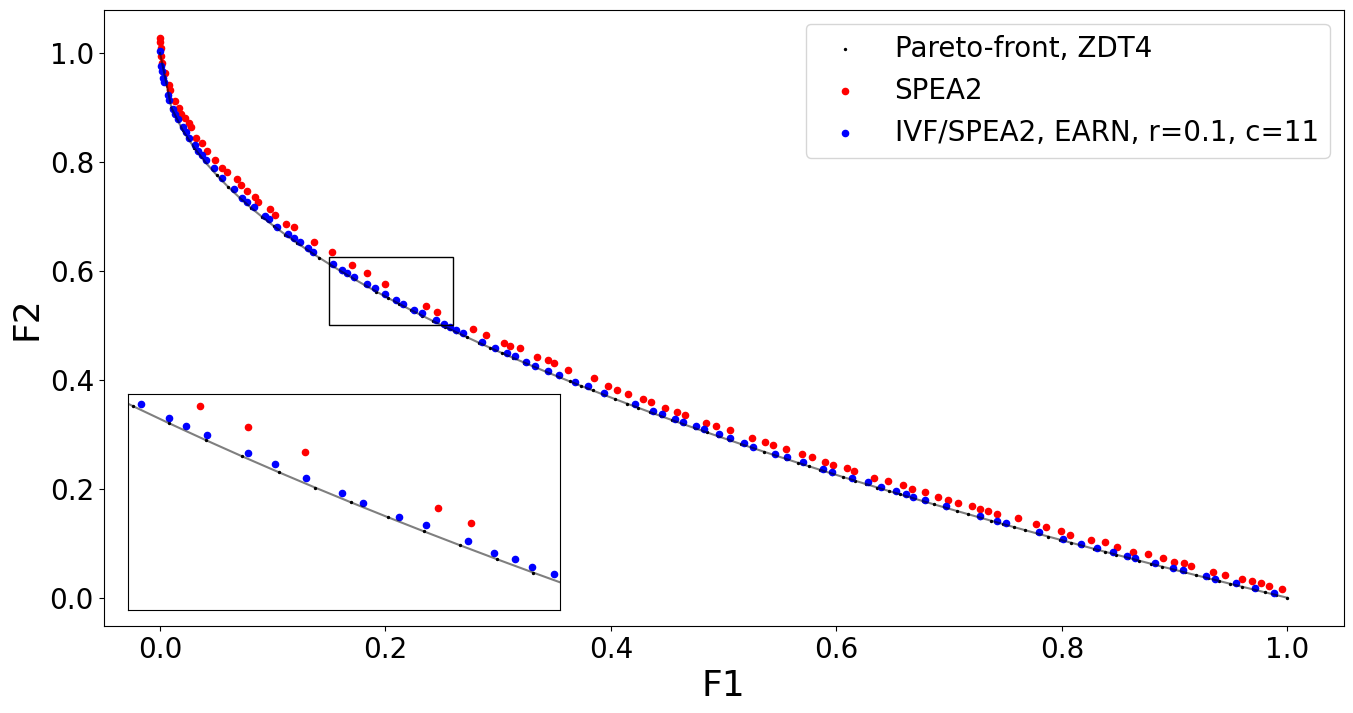

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.spea2 import SPEA2
from pymoo.optimize import minimize
from pymoo.problems import get_problem
from matplotlib.patches import Circle
import matplotlib.patches as mpatches
from pymoo.termination import get_termination

# Definir o problema de otimização
problem = get_problem("ZDT4")

# Definir as configurações do algoritmo IVFSPEA2
pop_size = 100
termination = get_termination("n_eval", 20000)

# Criar uma instância do algoritmo IVFSPEA2
invit = InVitroFertilizationSPEA2(numIndv=11, taxa_exec=0.1, prob_var=0.5, prob_mae=-1, EARN=True)

# Definir o número de execuções
num_executions = 30

# Listas para armazenar os resultados das execuções
results_ivfspea2 = []
results_spea2 = []

# Alterar o tamanho da figura
plt.figure(figsize=(16, 8))

# Executar as otimizações para as 30 execuções
for seed in range(17, 17 + 1):
  # Criar uma instância do algoritmo IVFSPEA2
  algorithm = IVFSPEA2(
      pop_size=100,
      IVF=invit,
      seed=seed,
      termination=termination,
      eliminate_duplicates=True
  )

  # Criar uma instância do algoritmo SPEA2 canônico
  canonical_algorithm = SPEA2(
      pop_size=100,
      seed=seed,
      termination=termination,
      eliminate_duplicates=True
  )

  pf = problem.pareto_front(use_cache=False)

  # Executar a otimização com ambos os algoritmos
  result_ivfspea2 = minimize(problem, algorithm, termination=termination)
  result_spea2 = minimize(problem, canonical_algorithm, termination=termination)

  # Obter os valores da convergência dos algoritmos
  convergence_ivfspea2 = result_ivfspea2.F
  convergence_spea2 = result_spea2.F

  plt.plot(pf[:, 0], pf[:, 1], alpha=0.5, color="black")
  plt.scatter(pf[:, 0], pf[:, 1], color="black", s=2, marker='o', label="Pareto-front, ZDT4")

  #plt.plot(convergence_spea2[:, 0], convergence_spea2[:, 1], alpha=0.5, linewidth=2.0, color="red")
  plt.scatter(convergence_spea2[:, 0], convergence_spea2[:, 1], color='red', s=20, marker='o', label='SPEA2')

  # Plot das bolinhas nas soluções de Pareto
  #plt.plot(convergence_ivfspea2[:, 0], convergence_ivfspea2[:, 1], alpha=0.5, linewidth=2.0,color='blue')
  plt.scatter(convergence_ivfspea2[:, 0], convergence_ivfspea2[:, 1],  color='blue', s=20, marker='o', label='IVF/SPEA2, EARN, r=0.1, c=11')

  # Configurações do plot
  plt.xlabel('F1', fontsize=26)
  plt.ylabel('F2', fontsize=26)

  plt.legend(fontsize=20)

  plt.tick_params(axis='both', which='major', labelsize=20)
  plt.tick_params(axis='both', which='minor', labelsize=20)

  rect=mpatches.Rectangle((0.15,0.5),0.11,0.125,
                        fill = False,
                        color = "black",
                        linewidth = 1)
  plt.gca().add_patch(rect)

  # Adicionar o quadrado de zoom
  ax_zoom = plt.axes([0.14, 0.13, 0.20+0.07, 0.20+0.07])  # Coordenadas e tamanho do quadrado de zoom
  ax_zoom.plot(pf[:, 0], pf[:, 1], alpha=0.5, color="black")
  ax_zoom.scatter(pf[:, 0], pf[:, 1], color="black", s=2, marker='o')
  ax_zoom.scatter(convergence_spea2[:, 0], convergence_spea2[:, 1], color='red', s=20, marker='o')
  ax_zoom.scatter(convergence_ivfspea2[:, 0], convergence_ivfspea2[:, 1],  color='blue', s=20, marker='o')
  ax_zoom.set_xlim(0.15, 0.27)  # Limites do eixo x
  ax_zoom.set_ylim(0.46, 0.62)  # Limites do eixo y
  ax_zoom.set_xticks([])
  ax_zoom.set_yticks([])

# Exibição do plot
plt.savefig('PF_ZDT4.pdf')
plt.show()


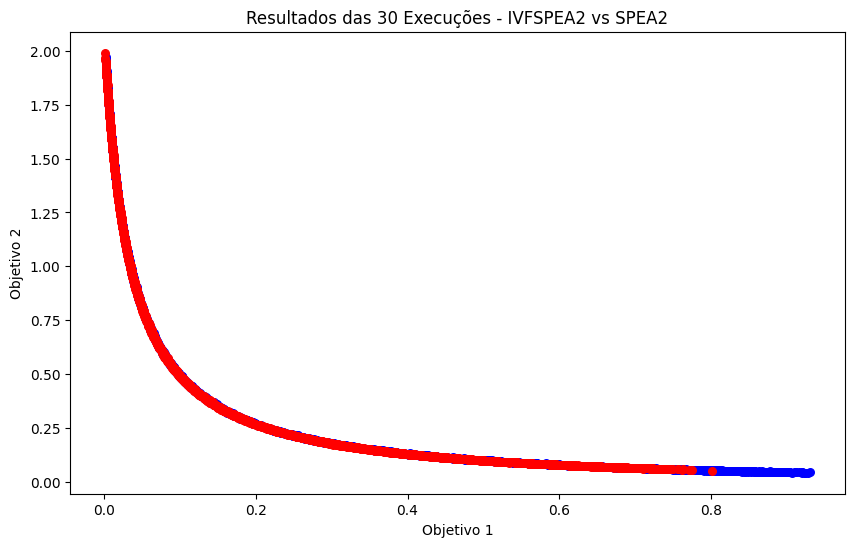

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.spea2 import SPEA2
from pymoo.optimize import minimize
from pymoo.problems import get_problem
from pymoo.termination import get_termination


# Definir o problema de otimização
problem = get_problem("ZDT5")

# Definir as configurações do algoritmo IVFSPEA2
pop_size = 100
termination = get_termination("n_eval", 20000)

# Criar uma instância do algoritmo IVFSPEA2
invit = InVitroFertilizationSPEA2(numIndv=15, taxa_exec=0.3, prob_var=0.5, prob_mae=0.5, EARN=True)

# Definir o número de execuções
num_executions = 30

# Listas para armazenar os resultados das execuções
results_ivfspea2 = []
results_spea2 = []

# Executar as otimizações para as 30 execuções
for seed in range(1, num_executions + 1):
    # Criar uma instância do algoritmo IVFSPEA2 com a seed atual
    algorithm = IVFSPEA2(
        pop_size=100,
        IVF=invit,
        seed=seed,
        termination=termination,
        eliminate_duplicates=True
    )

    # Criar uma instância do algoritmo SPEA2 canônico com a seed atual
    canonical_algorithm = SPEA2(
        pop_size=100,
        seed=seed,
        termination=termination,
        eliminate_duplicates=True
    )

    # Executar a otimização com ambos os algoritmos
    result_ivfspea2 = minimize(problem, algorithm, termination=termination, seed = seed)
    result_spea2 = minimize(problem, canonical_algorithm, termination=termination, seed = seed)

    # Armazenar os resultados
    results_ivfspea2.append(result_ivfspea2)
    results_spea2.append(result_spea2)

# Configurar o plot
plt.figure(figsize=(10, 6))
plt.title('Resultados das 30 Execuções - IVFSPEA2 vs SPEA2')
plt.xlabel('Objetivo 1')
plt.ylabel('Objetivo 2')

# Plotar os gráficos das 30 execuções para IVFSPEA2
for i in range(num_executions):
    convergence_ivfspea2 = results_ivfspea2[i].F
    plt.scatter(convergence_ivfspea2[:, 0], convergence_ivfspea2[:, 1], color='blue', s=30, label='IVF/SPEA2', marker='o')

# Plotar os gráficos das 30 execuções para SPEA2
for i in range(num_executions):
    convergence_spea2 = results_spea2[i].F
    plt.scatter(convergence_spea2[:, 0], convergence_spea2[:, 1], color='red', label='SPEA2', s=30, marker='o')

# Exibir o plot
plt.show()


n_gen  |  n_eval  | n_nds  |      igd      |       gd      |       hv     
     1 |      100 |     23 |  0.2521647236 |  0.2221350072 |  0.5024414449
     2 |      200 |     23 |  0.2436858450 |  0.1978883363 |  0.5163716345
     3 |      300 |     15 |  0.2316064386 |  0.1971827656 |  0.5582606710
     4 |      400 |     15 |  0.2257203155 |  0.1799734185 |  0.5951494847
     5 |      500 |     16 |  0.2253162002 |  0.1806757717 |  0.5960876030
     6 |      600 |     23 |  0.2050663764 |  0.1734871495 |  0.6261440122
     7 |      700 |     26 |  0.1983745182 |  0.1704314246 |  0.6467231935
     8 |      800 |     32 |  0.1873202326 |  0.1608131186 |  0.6559303588
     9 |      900 |     40 |  0.1873874914 |  0.1536771695 |  0.6861930449
    10 |     1000 |     40 |  0.1843671606 |  0.1487996672 |  0.6896823846
    11 |     1100 |     46 |  0.1801480141 |  0.1436450177 |  0.7002312282
    12 |     1200 |     48 |  0.1608163561 |  0.1369581990 |  0.7112423086
    13 |     1300 |     5

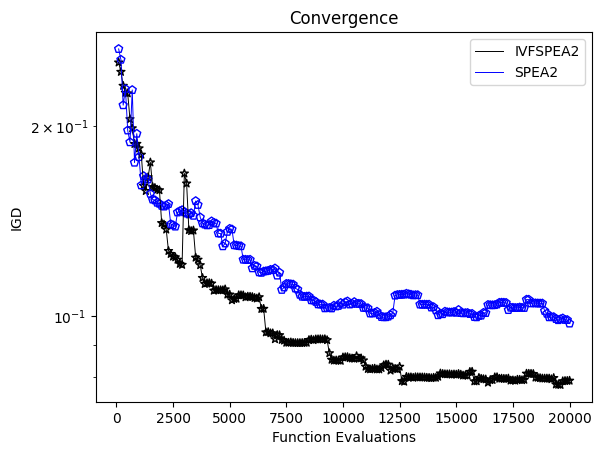

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.spea2 import SPEA2
from pymoo.optimize import minimize
from pymoo.problems import get_problem
from pymoo.termination import get_termination
from pymoo.indicators.igd import IGD

# Definir o problema de otimização
problem = get_problem("ZDT5")

# Definir as configurações do algoritmo IVFSPEA2
pop_size = 100
invit = InVitroFertilizationSPEA2(numIndv=15, taxa_exec=0.3, prob_var=-1, prob_mae=0.5, EARN=True)
ivf = invit
seed = 18
termination = get_termination("n_eval", 20000)
eliminate_duplicates = True

# Criar uma instância do algoritmo IVFSPEA2
algorithm = IVFSPEA2(pop_size=pop_size, IVF=ivf, seed=seed,  eliminate_duplicates=eliminate_duplicates)

# Criar uma instância do algoritmo SPEA2 canônico
canonical_algorithm = SPEA2(pop_size=pop_size, seed=4, eliminate_duplicates=eliminate_duplicates)

# Executar a otimização com ambos os algoritmos
result_ivfspea2 = minimize(problem, algorithm, termination, seed=18, verbose=True, save_history=True)
result_spea2 = minimize(problem, canonical_algorithm,termination, seed=4, verbose=True, save_history=True)

X1, F2 = result_ivfspea2.opt.get("X", "F")
X1, F2 = result_spea2.opt.get("X", "F")

hist1 = result_ivfspea2.history
hist2 = result_spea2.history

n_evals = []             # corresponding number of function evaluations\
hist_F = []              # the objective space values in each generation
hist_cv = []             # constraint violation in each generation
hist_cv_avg = []         # average constraint violation in the whole population

for algo in hist1:

    # store the number of function evaluations
    n_evals.append(algo.evaluator.n_eval)

    # retrieve the optimum from the algorithm
    opt = algo.opt

    # store the least contraint violation and the average in each population
    hist_cv.append(opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())

    # filter out only the feasible and append and objective space values
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])

n_evals2 = []             # corresponding number of function evaluations\
hist_F2 = []              # the objective space values in each generation
hist_cv2 = []             # constraint violation in each generation
hist_cv_avg2 = []         # average constraint violation in the whole population

for algo in hist2:

    # store the number of function evaluations
    n_evals2.append(algo.evaluator.n_eval)

    # retrieve the optimum from the algorithm
    opt = algo.opt

    # store the least contraint violation and the average in each population
    hist_cv2.append(opt.get("CV").min())
    hist_cv_avg2.append(algo.pop.get("CV").mean())

    # filter out only the feasible and append and objective space values
    feas = np.where(opt.get("feasible"))[0]
    hist_F2.append(opt.get("F")[feas])


pf = problem.pareto_front(use_cache=False)
metric = IGD(pf, zero_to_one=True)

igd = [metric.do(_F) for _F in hist_F]

igd2 = [metric.do(_F) for _F in hist_F2]


plt.plot(n_evals, igd,  color='black', lw=0.7, label="IVFSPEA2")
plt.scatter(n_evals, igd,  facecolor="none", edgecolor='black', marker="*")
plt.plot(n_evals2, igd2,  color='blue', lw=0.7, label="SPEA2")
plt.scatter(n_evals2, igd2,  facecolor="none", edgecolor='blue', marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("IGD")
plt.yscale("log")
plt.legend()
plt.show()


#Teste

In [ ]:
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.operators.mutation.gauss import GM

invit = InVitroFertilizationSPEA2(numIndv = 11, taxa_exec=0.9, prob_mae=0.5, prob_var=0.5)
termination = DefaultMultiObjectiveTermination(
    xtol=1e-8,
    cvtol=1e-6,
    ftol=0.0025,
    period=30,
    n_max_gen=50000,
    n_max_evals=20000
)

algorithm = IVFSPEA2(
    pop_size=100,
    IVF = invit,
    eliminate_duplicates=True)

problem = get_problem("zdt4")

com_IVF = minimize(problem,
               algorithm,
               termination,
               seed=random.seed(),
               save_history = True,
               verbose=False)

hist = com_IVF.history
n_evals = []             # corresponding number of function evaluations\
hist_F = []              # the objective space values in each generation
hist_cv = []             # constraint violation in each generation
hist_cv_avg = []         # average constraint violation in the whole population

for algo in hist:

    # store the number of function evaluations
    n_evals.append(algo.evaluator.n_eval)

    # retrieve the optimum from the algorithm
    opt = algo.opt

    # store the least contraint violation and the average in each population
    hist_cv.append(opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())

    # filter out only the feasible and append and objective space values
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])

metric = IGD(pf, zero_to_one=True)

igd = [metric.do(_F) for _F in hist_F]

print(igd[49])


plt.plot(n_evals, igd,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, igd,  facecolor="none", edgecolor='black', marker="p")
plt.axhline(10**-2, color="red", label="10^-2", linestyle="--")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("IGD")
plt.yscale("log")
plt.legend()
plt.show()

NameError: ignored

In [ ]:
import datetime

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.problems import get_problem

invit = InVitroFertilizationSPEA2(numIndv = 11, taxa_exec=0.9, prob_mae=0.5, prob_var=0.5)
termination = DefaultMultiObjectiveTermination(
    xtol=1e-8,
    cvtol=1e-6,
    ftol=0.0025,
    period=30,
    n_max_gen=50000,
    n_max_evals=20000
)

algorithm = IVFSPEA2(
    pop_size=100,
    IVF = invit,
    eliminate_duplicates=True)

problem = get_problem("zdt4")

# prepare the algorithm to solve the specific problem (same arguments as for the minimize function)
algorithm.setup(problem, termination=termination, seed=1, verbose=False)

# until the algorithm has no terminated
while algorithm.has_next():

    # do the next iteration
    algorithm.next()

    # do same more things, printing, logging, storing or even modifying the algorithm object
    print(algorithm.n_gen, algorithm.evaluator.n_eval)


# obtain the result objective from the algorithm
res = algorithm.result()

# calculate a hash to show that all executions end with the same result
print("hash", res.F.sum())

2 100
3 200
4 300
5 400
6 500
7 600
8 700
9 800
10 900
11 1000
12 1100
13 1200
14 1300
15 1400
16 1500
17 1600
18 1700
19 1800
20 1900
21 2000
22 2100
23 2200
24 2300
25 2400
26 2500
27 2600
28 2700
29 2800
30 2900
31 3000
32 3100
33 3200
34 3300
35 3400
36 3500
37 3600
38 3700
39 3800
40 3900
41 4000
42 4100
43 4200
44 4300
45 4400
46 4500
47 4600
48 4700
49 4800
50 4900
51 5000
52 5100
53 5200
54 5300
55 5400
56 5500
57 5600
58 5700
59 5800
60 5900
61 6000
62 6100
63 6200
64 6300
65 6400
66 6500
67 6600
68 6700
69 6800
70 6900
71 7000
72 7100
73 7200
74 7300
75 7400
76 7500
77 7600
78 7700
79 7800
80 7900
81 8000
82 8100
83 8200
84 8300
85 8400
86 8500
87 8600
88 8700
89 8800
90 8900
91 9000
92 9100
93 9200
94 9300
95 9400
96 9500
97 9600
98 9700
99 9800
100 9900
101 10000
102 10100
103 10200
104 10300
105 10400
106 10500
107 10600
108 10700
109 10800
110 10900
111 11000
112 11100
113 11200
114 11300
115 11400
116 11500
117 11600
118 11700
119 11800
120 11900
121 12000
122 12100
123 

In [ ]:
from pymoo.indicators.igd import IGD
invit = InVitroFertilizationSPEA2(numIndv = 11, taxa_exec=0.7,  EARN=True)

algorithm = IVFSPEA2(
    pop_size=100,
    IVF = invit,
    eliminate_duplicates=True)

problem = get_problem("ZDT4")
pf = problem.pareto_front(use_cache=False)

metric = IGD(pf, zero_to_one=True)
igdata, t_pop, evals_max, evals_ivf, n_gens = exec_algoritm_igd(problem, algorithm)

print(igdata)
print(t_pop)
print(evals_max)
print(evals_ivf)
print(n_gens)


[17.185922904128343, 19.832160198735174, 22.708612632433436, 32.16098866537304, 31.368683773079944, 30.435618805045916, 39.0183444968272, 45.488745773790384, 24.374475350047604, 24.93687492948413, 28.46186049894724, 39.72828598274468, 34.14962005693415, 35.47146256851006, 35.05380411693571, 41.723974962525446, 24.88436060344629, 39.942815353336954, 30.831113520680994, 27.710610548832047, 41.34561358254847, 32.54987048026829, 29.214436269510976, 24.622154294879785, 25.958257168300044, 37.44937995304679, 28.661681866089513, 33.20653459851148, 37.848919273477634, 39.621360262233914]
[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
[180, 240, 240, 160, 380, 240, 240, 160, 220, 260, 240, 140, 180, 140, 180, 220, 

#Base comparação

In [ ]:
import pandas as pd

tabela = pd.DataFrame(
    columns = ['IGD','RUN', 'r', 'c', 'm', 'v','EAR', 'ALGORITHM', 'PROBLEM']
)

tabela.to_csv('TESTE_inicial.csv')

In [ ]:
tabela

,IGD,RUN,CONFIG,ALGORITHM,PROBLEM


In [ ]:
base = base.append(pd.Series([1, 1, 1, 1, 1], index=base.columns), ignore_index=True)

In [ ]:
print(2 not in base['RUN'].values)

True


In [ ]:
base.to_csv('BASE_DADOS.csv')

In [ ]:
ds = pd.read_csv('BASE_DADOS.csv', index_col=0)
ds

,IGD,RUN,CONFIG,ALGORITHM,PROBLEM
0,1,1,1,1,1


In [ ]:
from scipy.stats import ranksums
def exec_algoritm_igd(problem, algorithm):
  igd_dados = []
  for i in range(30):
    line = []

    spea1 = minimize(problem,
                  algorithm,
                  ('n_gen', 100),
                  seed= random.seed(None),
                  save_history=True,
                  verbose=False)

    X, F = spea1.opt.get("X", "F")
    hist = spea1.history

    n_evals = []             # corresponding number of function evaluations\
    hist_F = []              # the objective space values in each generation
    hist_cv = []             # constraint violation in each generation
    hist_cv_avg = []         # average constraint violation in the whole population

    for algo in hist:

        # store the number of function evaluations
        n_evals.append(algo.evaluator.n_eval)

        # retrieve the optimum from the algorithm
        opt = algo.opt

        # store the least contraint violation and the average in each population
        hist_cv.append(opt.get("CV").min())
        hist_cv_avg.append(algo.pop.get("CV").mean())

        # filter out only the feasible and append and objective space values
        feas = np.where(opt.get("feasible"))[0]
        hist_F.append(opt.get("F")[feas])

    igd = [metric.do(_F) for _F in hist_F]
    igd_dados.append(igd[len(igd)-1])

  return igd_dados.copy()

#Teste comparação

In [ ]:
pip install python-fcl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -r requirements.txt
!python setup.py install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
python3: can't open file 'setup.py': [Errno 2] No such file or directory


In [ ]:
from pymoo.indicators.igd import IGD
import random
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.spea2 import SPEA2
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.mutation.gauss import GM
from pymoo.operators.mutation.nom import NoMutation
from pymoo.problems.multi import MODAct

import matplotlib.pyplot as plt
import numpy as np


for j in range(1,2):

  problem = get_problem("zdt1")
  #problem = MODAct(f"cs{j}")
  pf = problem.pareto_front(use_cache=False)

  metric = IGD(pf, zero_to_one=True)


     #####################    SPEA    ##########################

  #invit1 = InVitroFertilizationSPEA2(mutEAR = PolynomialMutation(prob = 1.0), numIndv = 11, taxa_exec=0.9, taxa_evals=0.5, EARP=True)

  algorithm = SPEA2(
    pop_size=100,
    #IVF = invit1,
    eliminate_duplicates=True)

  data_1 = exec_algoritm_igd(problem, algorithm)

  #####################    NSGA    ##########################

  invit1 = InVitroFertilizationSPEA2(mutEAR = PolynomialMutation(prob = 1.0), numIndv = 9, taxa_exec=0.9, taxa_evals=0.5, EARP=True)

  algorithm = IVFSPEA2(
    pop_size=100,
    IVF = invit1,
    eliminate_duplicates=True)

  data_2 = exec_algoritm_igd(problem, algorithm)

  #####################    SPEA    ##########################


  invit2 = InVitroFertilizationSPEA2(mutEAR = PolynomialMutation(prob = 1.0), numIndv = 9, taxa_exec=0.9, taxa_evals=0.5, EART = True)


  algorithm = IVFSPEA2(
      pop_size=100,
      IVF = invit2,
      eliminate_duplicates=True)

  data_3 = exec_algoritm_igd(problem, algorithm)

  invit3 = InVitroFertilizationSPEA2(mutEAR = PolynomialMutation(prob = 1.0), numIndv = 9, taxa_exec=0.9, taxa_evals=0.5, EART = False, EARP = False)


  algorithm = IVFSPEA2(
      pop_size=100,
      IVF = invit2,
      eliminate_duplicates=True)

  data_4 = exec_algoritm_igd(problem, algorithm)

  data = [data_1, data_2, data_3, data_4]

  faz_grafico(data, j)



[0.005151787813418785, 0.005838753779666137, 0.004885660788717421, 0.005282649358893162, 0.006062011655956177, 0.005328513521322018, 0.005601568888801244, 0.005555199562876902, 0.005235563003639285, 0.005204677176952773, 0.005765592222384524, 0.005504637180447234, 0.005772829163294794, 0.004953803257581049, 0.0055670311282132005, 0.005258964942960183, 0.004836845754575118, 0.005308663977883813, 0.00566100784388502, 0.005600819757368127, 0.005129968259809579, 0.005236545158352014, 0.004616849676773452, 0.005224711098903615, 0.00581115222564748, 0.005484063210355539, 0.00519145595336012, 0.005020804233020999, 0.005555771250845158, 0.00527318147739743]


KeyboardInterrupt: ignored

##Gerando os valores

In [ ]:
import pandas as pd
r = [0.3, .5, .7, .9]
c = [7, 11, 19]
m = [0.1, 0.3, 0.5]
v = [0.3, 0.5, 0.9]
nomesrc = []
nomesmv = []

for j in m:
  for k in v:
    nomesmv.append(f'm={j}, v={k}')
for j in r:
  for k in c:
    nomesrc.append(f'r={j}, c={k}')

tabela = pd.DataFrame(
    index = nomesmv,
    columns = nomesrc
)


tabela


,"r=0.3, c=7","r=0.3, c=11","r=0.3, c=19","r=0.5, c=7","r=0.5, c=11","r=0.5, c=19","r=0.7, c=7","r=0.7, c=11","r=0.7, c=19","r=0.9, c=7","r=0.9, c=11","r=0.9, c=19"
"m=0.1, v=0.3",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"m=0.1, v=0.5",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"m=0.1, v=0.9",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"m=0.3, v=0.3",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"m=0.3, v=0.5",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"m=0.3, v=0.9",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"m=0.5, v=0.3",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"m=0.5, v=0.5",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"m=0.5, v=0.9",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import pandas as pd
tabela = pd.read_csv("Data_SPEA2_InVit_ZDT4.csv", index_col=0)

In [ ]:
tabela_pvalues = pd.read_csv("Data_SPEA2_InVit_pvalues_ZDT4.csv", index_col=0)

In [ ]:
tabela

,"r=0.1, c=5","r=0.1, c=7","r=0.1, c=11","r=0.1, c=19","r=0.3, c=5","r=0.3, c=7","r=0.3, c=11","r=0.3, c=19","r=0.5, c=5","r=0.5, c=7","r=0.5, c=11","r=0.5, c=19","r=0.7, c=5","r=0.7, c=7","r=0.7, c=11","r=0.7, c=19","r=0.9, c=5","r=0.9, c=7","r=0.9, c=11","r=0.9, c=19"
"m=1, e=0.3",0.751916,0.716613,0.599501,0.652124,0.666800,0.503584,0.465159,0.565527,0.568340,0.488629,0.533170,0.548782,0.454314,0.433291,0.470081,0.471935,0.531366,0.482298,0.504119,0.511205
"m=1, e=0.5",0.623103,0.593449,0.599066,0.643395,0.633145,0.576308,0.526777,0.654703,0.596282,0.466939,0.444953,0.512483,0.511727,0.449439,0.488279,0.459933,0.489732,0.366976,0.412654,0.468799
"m=1, e=0.7",0.605495,0.631209,0.599224,0.581342,0.508772,0.532545,0.542769,0.647563,0.513017,0.398408,0.452291,0.523018,0.488137,0.428385,0.432398,0.491142,0.467202,0.480961,0.437242,0.456670
"m=1, e=0.9",0.589927,0.682377,0.626369,0.563447,0.485386,0.497922,0.480794,0.538288,0.508364,0.493321,0.561876,0.614528,0.495031,0.447230,0.526953,0.448723,0.497362,0.383393,0.493196,0.527977
"m=2, e=0.3",0.656659,0.583150,0.604587,0.718398,0.634324,0.502893,0.533418,0.536800,0.466552,0.486205,0.422469,0.445471,0.460945,0.482876,0.441155,0.478636,0.513462,0.437918,0.417736,0.389589
"m=2, e=0.5",0.606756,0.615112,0.574514,0.667282,0.619136,0.624767,0.559192,0.523732,0.483619,0.472606,0.428241,0.549174,0.498589,0.517727,0.434287,0.485155,0.483311,0.502433,0.451352,0.515650
"m=2, e=0.7",0.628912,0.668125,0.598613,0.624728,0.608059,0.543121,0.515631,0.567326,0.552838,0.448286,0.423594,0.589025,0.468569,0.481502,0.514937,0.448472,0.404990,0.424536,0.389651,0.458038
"m=2, e=0.9",0.580027,0.568433,0.599275,0.620484,0.522563,0.461040,0.520410,0.536953,0.554595,0.463875,0.414808,0.553974,0.539323,0.455842,0.466258,0.558753,0.431525,0.390800,0.508636,0.482371
"m=3, e=0.3",0.781190,0.620116,0.604072,0.651472,0.694376,0.485824,0.450756,0.577224,0.592933,0.499967,0.495688,0.440596,0.504449,0.480071,0.439371,0.568250,0.519985,0.378667,0.397579,0.382723
"m=3, e=0.5",0.652481,0.610261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
tabela_pvalues

,"r=0.1, c=5","r=0.1, c=7","r=0.1, c=11","r=0.1, c=19","r=0.3, c=5","r=0.3, c=7","r=0.3, c=11","r=0.3, c=19","r=0.5, c=5","r=0.5, c=7","r=0.5, c=11","r=0.5, c=19","r=0.7, c=5","r=0.7, c=7","r=0.7, c=11","r=0.7, c=19","r=0.9, c=5","r=0.9, c=7","r=0.9, c=11","r=0.9, c=19"
"m=1, e=0.3",2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11
"m=1, e=0.5",2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11
"m=1, e=0.7",2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11
"m=1, e=0.9",2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11
"m=2, e=0.3",2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11
"m=2, e=0.5",2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11
"m=2, e=0.7",2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11
"m=2, e=0.9",2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11
"m=3, e=0.3",2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11,2.871949e-11
"m=3, e=0.5",2.871949e-11,2.871949e-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Pratica2

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.colors as colors
from pymoo.indicators.igd import IGD
import seaborn as sns
from pymoo.algorithms.moo.spea2 import SPEA2
from matplotlib.colors import ListedColormap
import pandas as pd
from scipy.stats import wilcoxon
import os

problem = get_problem("ZDT6")
%cd /content/drive/MyDrive/Data_artigo/Data_1000000/ZDT6
pf = problem.pareto_front(use_cache=False)

#Taxa de execução IVF
r = [0.1, 0.3, 0.5, 0.7, 0.9]
#Tamanho de coleta IVF
c = [5, 7, 11, 15, 19, 23]
#Porcentagem de mães utilizadas na primeira fase do EAR
m = [0, 0.1, 0.2, 0.25, 0.3, 0.4,  0.5]
#Porcentagem de variáveis modificadas das mães escolhidas
v = [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]

for j in r:
  for k in c:
    if os.path.isfile(f'/content/drive/MyDrive/Data_artigo/Data_1000000/ZDT6/DATA_{j}_{k}_EARN.csv'):
      print("Já existe: ", f'DATA_{j}_{k}_EARN.csv')
      continue
    else:
      print("Executando: ", f'DATA_{j}_{k}_EARN.csv')
    df = pd.DataFrame( columns = ['IGD','RUN', 'r', 'c', 'm', 'v','EAR', 'ALGORITHM', 'PROBLEM', 'T_POP', 'N_GENS', 'TOT_AVALS', 'IVF_AVALS'])
    line = []

    pf = problem.pareto_front(use_cache=False)

    metric = IGD(pf, zero_to_one=True)
    invit = InVitroFertilizationSPEA2(numIndv = k, taxa_exec=j,  EARN=True)

    algorithm = IVFSPEA2(
        pop_size=100,
        IVF = invit,
        eliminate_duplicates=True)
    igdata, t_pop, evals_max, evals_ivf, n_gens = exec_algoritm_igd(problem, algorithm)
    cont = 1
    for aux in range(30):
      line = [igdata[aux], cont, j, k, 0.5, -1, 'EARN' , 'IVF/SPEA2', 'ZDT6', t_pop[aux], n_gens[aux], evals_max[aux], evals_ivf[aux]]
      df = df.append(pd.Series(line, index=df.columns), ignore_index=True)
      cont += 1
      line = []

    df.to_csv(f'DATA_{j}_{k}_EARN.csv')

/content/drive/MyDrive/Data_artigo/Data_1000000/ZDT6
Executando:  DATA_0.1_5_EARN.csv


TypeError: ignored

In [ ]:
from scipy.stats import ranksums
from pymoo.termination.default import DefaultMultiObjectiveTermination

termination = DefaultMultiObjectiveTermination(
    xtol=1e-8,
    cvtol=1e-6,
    ftol=0.0025,
    period=30,
    n_max_gen=200,
    n_max_evals=20000
)
def exec_algoritm_plt(problem, algorithm):
  igd_dados = []
  for i in range(30):
    line = []

    spea1 = minimize(problem,
                  algorithm,
                  termination,
                  seed= random.seed(None),
                  save_history=True,
                  verbose=False)

    X, F = spea1.opt.get("X", "F")
    hist = spea1.history

    n_evals = []             # corresponding number of function evaluations\
    hist_F = []              # the objective space values in each generation
    hist_cv = []             # constraint violation in each generation
    hist_cv_avg = []         # average constraint violation in the whole population

    for algo in hist:

        # store the number of function evaluations
        n_evals.append(algo.evaluator.n_eval)

        # retrieve the optimum from the algorithm
        opt = algo.opt

        # store the least contraint violation and the average in each population
        hist_cv.append(opt.get("CV").min())
        hist_cv_avg.append(algo.pop.get("CV").mean())

        # filter out only the feasible and append and objective space values
        feas = np.where(opt.get("feasible"))[0]
        hist_F.append(opt.get("F")[feas])

    igd = [metric.do(_F) for _F in hist_F]
    igd_dados.append(igd[len(igd)-1])


  pf = problem.pareto_front(use_cache=False)
  plt.scatter(pf[:,0], pf[:,1], color='blue', alpha=0.5)
  for i in range(30):
      plt.plot(hist_F[i][:,0], hist_F[i][:,1], color='red', alpha=0.5)
  plt.title('Fronteiras obtidas em comparação com a fronteira de Pareto')
  plt.xlabel('f1')
  plt.ylabel('f2')
  plt.show()

  return igd_dados.copy()

In [ ]:
from pymoo.indicators.igd import IGD
invit = InVitroFertilizationSPEA2(numIndv = 11, taxa_exec=0.7,  EARN=True)

algorithm = IVFSPEA2(
    pop_size=100,
    IVF = invit,
    eliminate_duplicates=True)

problem = get_problem("ZDT1")
pf = problem.pareto_front(use_cache=False)

metric = IGD(pf, zero_to_one=True)
print("\n\nFinalizado: ",exec_algoritm_igd(problem, algorithm),'\n')




Finalizado:  DATA_0.7_11_EARN.csv 



In [ ]:
import os

caminho_do_arquivo = '/content/drive/MyDrive/Data_artigo/Data/DATA_0.1_5_0_0.2_Base.csv'

if os.path.isfile(caminho_do_arquivo):
    print("O arquivo existe.")
else:
    print("O arquivo não existe.")

O arquivo não existe.


In [ ]:
import pandas as pd
df = pd.read_csv('BASE_DADOS.csv', index_col=0)
df_mod = df[df["PROBLEM"] == "ZDT4"]

# Calcule a média da coluna "IGD" para cada valor único na coluna "CONFIG"
mean_igd = df_mod.groupby("CONFIG")["IGD"].mean()

# Ordenar as médias em ordem crescente
mean_igd = mean_igd.sort_values()

# Selecionar as 10 menores médias
mean_igd = mean_igd[:1]

# Filtrar o dataframe original para incluir apenas as configurações com as 10 menores médias
df_mod = df_mod[df_mod["CONFIG"].isin(mean_igd.index)]

# Calcular os valores estatísticos para cada configuração
stats = df_mod.groupby("CONFIG").agg({"IGD": ["mean", "min", "max", "std"]})

# Formatar os nomes das colunas para incluir o nome da configuração
stats.columns = [f"{config}_{stat}" for config, stat in stats.columns]

# Adicionar a coluna "ALGORITHM" ao resultado
stats["ALGORITHM"] = df_mod.groupby("CONFIG")["ALGORITHM"].first()
# Criar a tabela em LaTeX
table = stats.to_latex(index=True, escape=False)

print(table)



\begin{tabular}{lrrrrl}
\toprule
{} &  IGD_mean &   IGD_min &   IGD_max &   IGD_std &  ALGORITHM \\
CONFIG                   &           &           &           &           &            \\
\midrule
r=0.9, c=19 / m=4, e=0.3 &  0.349829 &  0.036927 &  0.893274 &  0.203759 &  IVF/SPEA2 \\
\bottomrule
\end{tabular}



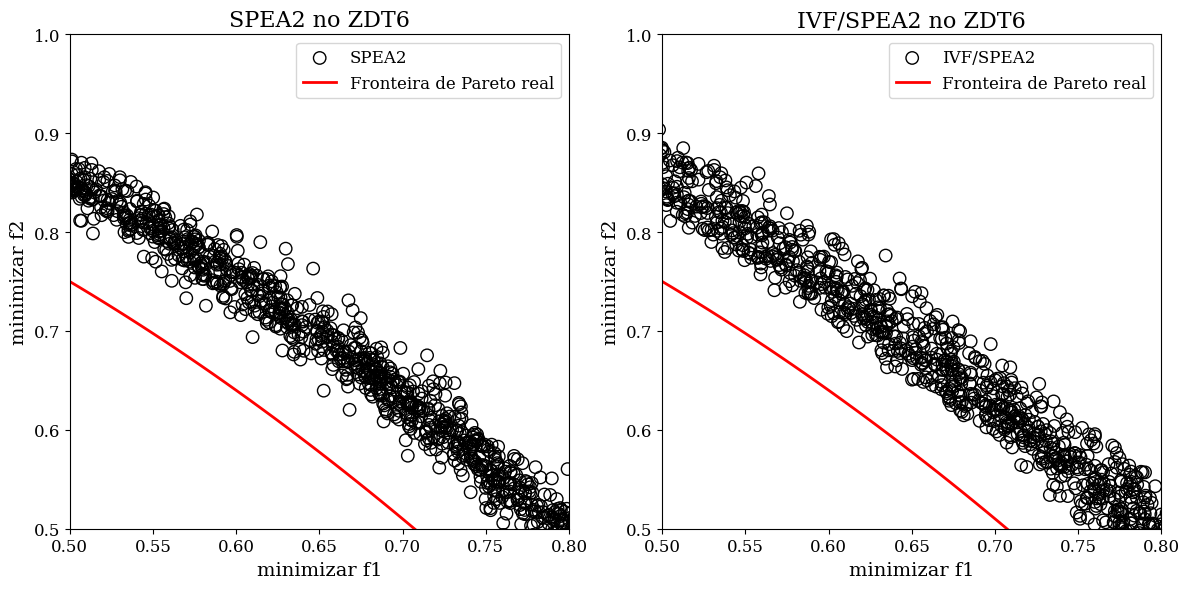

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.spea2 import SPEA2
from pymoo.problems import get_problem
from pymoo.optimize import minimize

problem = get_problem("ZDT6")

invit = InVitroFertilizationSPEA2(numIndv = 5, taxa_exec=0.9, EART = True)

algorithm = SPEA2(pop_size=100,
    eliminate_duplicates=True)

n_runs = 30
F_all = []
results = []

for i in range(n_runs):
    res = minimize(problem,
                   algorithm,
                   termination=('n_gen', 100),
                   seed=i,
                   verbose=False)
    results.append(res)
    F_all.append(res.opt.get("F"))


algorithm = IVFSPEA2(
              pop_size=100,
              IVF = invit,
              eliminate_duplicates=True)


n_runs = 30
F_all_1 = []
results_1 = []

for i in range(n_runs):
    res = minimize(problem,
                   algorithm,
                   termination=('n_gen', 100),
                   seed=i,
                   verbose=False)
    results_1.append(res)
    F_all_1.append(res.opt.get("F"))


# Calculate the true Pareto front
pf = problem.pareto_front()



# Criar uma figura com dois subplots lado a lado
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

# Configurar o primeiro subplot para o SPEA2
axs[0].set_title('SPEA2 no ZDT6', fontsize=16)
for i in range(n_runs):
    axs[0].scatter(F_all[i][:,0], F_all[i][:,1], s=80, edgecolors='black', facecolors='none', label='SPEA2' if i == 0 else None)
axs[0].plot(pf[:,0], pf[:,1], color='red', linewidth=2, label='Fronteira de Pareto real')
axs[0].set_xlabel('minimizar f1', fontsize=14)
axs[0].set_ylabel('minimizar f2', fontsize=14)
axs[0].tick_params(labelsize=12)
axs[0].set_xlim((0.5, 0.8))
axs[0].set_ylim((0.5, 1))
axs[0].legend(fontsize=12, loc='upper right')

# Configurar o segundo subplot para o NSGA-II
axs[1].set_title('IVF/SPEA2 no ZDT6', fontsize=16)
for i in range(n_runs):
    axs[1].scatter(F_all_1[i][:,0], F_all_1[i][:,1], s=80, edgecolors='black', facecolors='none', label='IVF/SPEA2' if i == 0 else None)
axs[1].plot(pf[:,0], pf[:,1], color='red', linewidth=2, label='Fronteira de Pareto real')
axs[1].set_xlabel('minimizar f1', fontsize=14)
axs[1].set_ylabel('minimizar f2', fontsize=14)
axs[1].tick_params(labelsize=12)
axs[1].set_xlim((0.5, 0.8))
axs[1].set_ylim((0.5, 1))
axs[1].legend(fontsize=12, loc='upper right')

# Ajustar o espaçamento entre os subplots
plt.tight_layout()

# Salvar a figura em PDF
plt.savefig('spea2_zdt6.pdf')

# Mostrar a figura
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.spea2 import SPEA2
from pymoo.factory import get_problem
from pymoo.indicators.igd import IGD
from pymoo.optimize import minimize

problem = get_problem("zdt4")

algorithm = SPEA2(pop_size=100)

n_runs = 30
F_all = []

# Calculate the true Pareto front
pf = problem.pareto_front()

# Calculate the IGD of each run
igd = IGD(pf)

for i in range(n_runs):
    res = minimize(problem,
                   algorithm,
                   termination=('n_gen', 100),
                   seed=i,
                   verbose=False)
    F_all.append(res.opt.get("F"))

# Select the best run
igd_values = [igd.calc(F_all[i]) for i in range(n_runs)]
best_run_idx = np.argmin(igd_values)
F_best = F_all[best_run_idx]

# Plot the results
plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(F_best[:,0], F_best[:,1], s=100, edgecolors='black', facecolors='none')
plt.plot(pf[:,0], pf[:,1], color='red', linewidth=2, label='Pareto Front')
plt.xlabel('f1', fontsize=14)
plt.ylabel('f2', fontsize=14)
plt.title('SPEA2 on ZDT4', fontsize=16)
plt.legend(fontsize=12, labels=['IVF/SPEA2', 'Pareto Front'], loc='upper right')
plt.tick_params(labelsize=12)
plt.xlim((0, 1.0))
plt.ylim((0, 3.0))
plt.tight_layout()
plt.show()


AttributeError: ignored

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.colors as colors
from pymoo.indicators.igd import IGD
import seaborn as sns
from pymoo.algorithms.moo.spea2 import SPEA2
from matplotlib.colors import ListedColormap
import pandas as pd
from scipy.stats import wilcoxon

problem = get_problem("ZDT4")

pf = problem.pareto_front(use_cache=False)

r = [0.1, 0.3, 0.5, 0.7, 0.9]
c = [5, 7, 11, 15, 19, 23]
m = [0, 0.1, 0.3, 0.5]
v = [0.1, 0.3, 0.5, 0.7, 1]

for j in r:
  for k in c:
    df = pd.read_csv('TESTE_inicial.csv', index_col=0)
    if(df.query(f'CONFIG == "r={j}, c={k} EARN" & PROBLEM=="ZDT4"').empty):
      print(f'r={j}, c={k} EARN')
      line = []

      metric = IGD(pf, zero_to_one=True)
      invit = InVitroFertilizationSPEA2(numIndv = k, taxa_exec=j,  EARN=True)

      algorithm = IVFSPEA2(
          pop_size=100,
          IVF = invit,
          eliminate_duplicates=True)

      igdata = exec_algoritm_igd(problem, algorithm)

      cont = 1
      for aux in igdata:
        line = [aux, cont, f'r={j}, c={k} EARN', 'IVF/SPEA2', 'ZDT4']
        df = df.append(pd.Series(line, index=df.columns), ignore_index=True)
        cont += 1
        line = []

      df.to_csv('TESTE_inicial.csv')


r=0.3, c=7 EARN
r=0.3, c=11 EARN
r=0.3, c=19 EARN
r=0.5, c=7 EARN
r=0.5, c=11 EARN
r=0.5, c=19 EARN
r=0.7, c=7 EARN
r=0.7, c=11 EARN
r=0.7, c=19 EARN
r=0.9, c=7 EARN
r=0.9, c=11 EARN
r=0.9, c=19 EARN


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.colors as colors
from pymoo.indicators.igd import IGD
import seaborn as sns
from pymoo.algorithms.moo.spea2 import SPEA2
from matplotlib.colors import ListedColormap
import pandas as pd
from scipy.stats import wilcoxon
import os

problem = get_problem("ZDT4")

pf = problem.pareto_front(use_cache=False)

r = [0.1, 0.3, 0.5, 0.7, 0.9]
c = [5, 7]
m = [0, 0.1, 0.3, 0.5]
v = [0.1, 0.3, 0.5, 0.7, 1]

for j in r:
  for k in c:
    if os.path.isfile(f'/content/drive/MyDrive/Data_artigo/Data/DATA_{j}_{k}_EARN.csv'):
      print("Já existe: ", f'DATA_{j}_{k}_EARN.csv')
      continue
    else:
      print("Executando: ", f'DATA_{j}_{k}_EARN.csv')
    df = pd.DataFrame( columns = ['IGD','RUN', 'r', 'c', 'm', 'v','EAR', 'ALGORITHM', 'PROBLEM'])
    line = []

    pf = problem.pareto_front(use_cache=False)

    metric = IGD(pf, zero_to_one=True)
    invit = InVitroFertilizationSPEA2(numIndv = k, taxa_exec=j,  EARN=True)

    algorithm = IVFSPEA2(
        pop_size=100,
        IVF = invit,
        eliminate_duplicates=True)
    igdata = exec_algoritm_igd(problem, algorithm)
    cont = 1
    for aux in igdata:
      line = [aux, cont, j, k, None, None, 'EARN' , 'IVF/SPEA2', 'ZDT4']
      df = df.append(pd.Series(line, index=df.columns), ignore_index=True)
      cont += 1
      line = []

    df.to_csv(f'DATA_{j}_{k}_EARN.csv')

Já existe:  DATA_0.1_5_EARN.csv
Já existe:  DATA_0.1_7_EARN.csv
Executando:  DATA_0.3_5_EARN.csv
Executando:  DATA_0.3_7_EARN.csv
Executando:  DATA_0.5_5_EARN.csv
Executando:  DATA_0.5_7_EARN.csv
Executando:  DATA_0.7_5_EARN.csv
Executando:  DATA_0.7_7_EARN.csv
Executando:  DATA_0.9_5_EARN.csv
Executando:  DATA_0.9_7_EARN.csv


In [ ]:
df = pd.read_csv('BASE_DADOS.csv', index_col=0)

cont = 1
for aux in igdata:
  line = [aux, cont, 'Puro', 'SPEA2', 'ZDT6']
  df = df.append(pd.Series(line, index=df.columns), ignore_index=True)
  cont += 1
  line = []

df.to_csv('BASE_DADOS.csv')


In [ ]:
df[(df['ALGORITHM'] == 'SPEA2') & (df['PROBLEM'] == 'ZDT6')]

,IGD,RUN,CONFIG,ALGORITHM,PROBLEM
72150,0.086722,1,Puro,SPEA2,ZDT6
72151,0.086492,2,Puro,SPEA2,ZDT6
72152,0.127946,3,Puro,SPEA2,ZDT6
72153,0.091079,4,Puro,SPEA2,ZDT6
72154,0.081744,5,Puro,SPEA2,ZDT6
72155,0.084691,6,Puro,SPEA2,ZDT6
72156,0.102693,7,Puro,SPEA2,ZDT6
72157,0.101565,8,Puro,SPEA2,ZDT6
72158,0.104522,9,Puro,SPEA2,ZDT6
72159,0.085965,10,Puro,SPEA2,ZDT6


In [ ]:
mask = (df['ALGORITHM'] == 'SPEA2') & (df['PROBLEM'] == 'ZDT5')

# Usando a máscara para excluir as linhas do DataFrame
df = df[~mask]


In [ ]:
print (igdata)

[0.005562199945695948, 0.005048525372842633, 0.004704400012978037, 0.0059504620314869625, 0.0054793450289090636, 0.004847485863330113, 0.005266974217435883, 0.005608729632976788, 0.0049361268673775716, 0.005292170557381643, 0.005016041541095041, 0.005233491310044715, 0.005356896734933016, 0.005899132505422705, 0.005557937642096824, 0.005595347650167134, 0.004794964133032203, 0.005271290224749887, 0.005140489776753922, 0.005061774152477522, 0.005489807539224858, 0.005639797684804142, 0.005210225913696095, 0.005634120611369778, 0.005223140020583311, 0.0047575619746853945, 0.005549084336941676, 0.004854274261208674, 0.00509664744765221, 0.00501548196540263]


#Testes Pratica

In [ ]:
pd.notna(tabela['r=0.1, c=5']['m=4, e=0.5'])

True

In [ ]:
tes = pd.read_csv('BASE_DADOS.csv', index_col=0)

In [ ]:
tes.query('CONFIG == "r=0.5, c=19 / m=5, e=0.3" & PROBLEM=="ZDT2"').empty

True

In [ ]:
plt.savefig("heatmap_in_matplotlib.png",
                    format='png',dpi=150)

#Testes HEATMAP

In [ ]:
%pip install mlxtend --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
teste = linha+[s_invitro, s_invitro]
orig_cmap = matplotlib.cm.coolwarm
vmin = min(map(min, linha+[[s_invitro, s_invitro]]))
vmax = max(map(max, linha+[[s_invitro, s_invitro]]))
norm = colors.TwoSlopeNorm(vmin= vmin-s_invitro/100, vcenter=s_invitro,vmax = vmax+ s_invitro/100 )
#print(s_invitro)
plt.subplots(figsize=(10,10))
plt.pcolor(linha, cmap = orig_cmap, vmin=vmin, vmax=vmax, norm=norm)
plt.xticks(np.arange(len(nomesrc)), labels=nomesrc, horizontalalignment = 'left' , rotation=20 )
plt.yticks(np.arange(len(nomesme)), labels=nomesme, verticalalignment = 'bottom', rotation=20)
plt.ylabel("MaxCycles(m) x MaxEvals(e)",size=15)
plt.xlabel("IvfRate(r) x Collect(c)",size=15)
plt.title("InVitro Fertilization - EARP - ZDT1")
plt.colorbar(label = 'Value')


NameError: ignored

Text(0.5, 1.0, 'Recentered cmap with function')

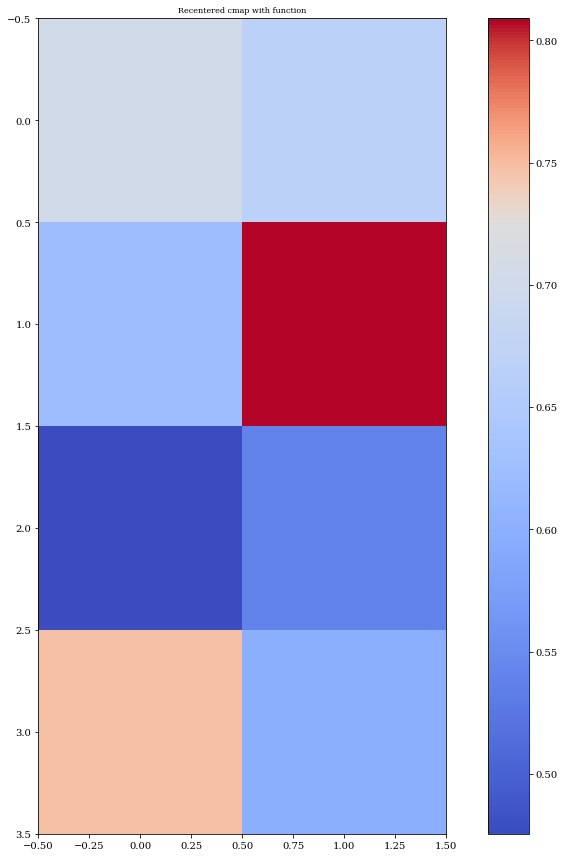

In [ ]:
orig_cmap = matplotlib.cm.coolwarm
shifted_cmap = shiftedColorMap(orig_cmap, midpoint=0.75, name='shifted')

fig, ax = plt.subplots(figsize=(15,15))

im2 = ax.imshow(linha, interpolation="none", cmap=shifted_cmap)
ax.figure.colorbar(im2)
ax.set_title('Recentered cmap with function', fontsize=8)

0.394087008323029 1.1619905507309105 1.1619905507309105


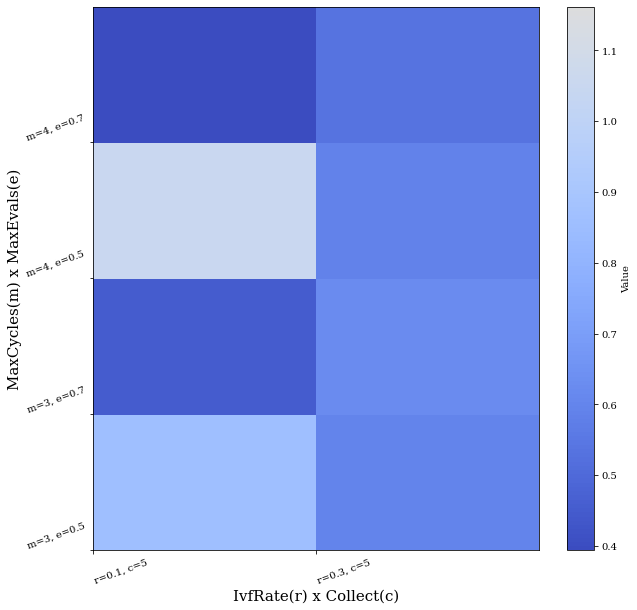

In [ ]:
import matplotlib.colors as colors

teste = linha+[s_invitro, s_invitro]
orig_cmap = matplotlib.cm.coolwarm
vmin = min(map(min, linha+[[s_invitro, s_invitro]]))
vmax = max(map(max, linha+[[s_invitro, s_invitro]]))
print(vmin,s_invitro, vmax )
norm = colors.TwoSlopeNorm(vmin= vmin-s_invitro/100, vcenter=s_invitro,vmax = vmax+ s_invitro/100 )
#print(s_invitro)
plt.subplots(figsize=(10,10))
plt.pcolor(linha, cmap = orig_cmap, vmin=vmin, vmax=vmax, norm=norm)
plt.xticks(np.arange(len(nomesrc)), labels=nomesrc, horizontalalignment = 'left' , rotation=20 )
plt.yticks(np.arange(len(nomesme)), labels=nomesme, verticalalignment = 'bottom', rotation=20)
plt.ylabel("MaxCycles(m) x MaxEvals(e)",size=15)
plt.xlabel("IvfRate(r) x Collect(c)",size=15)
plt.colorbar(label = 'Value')



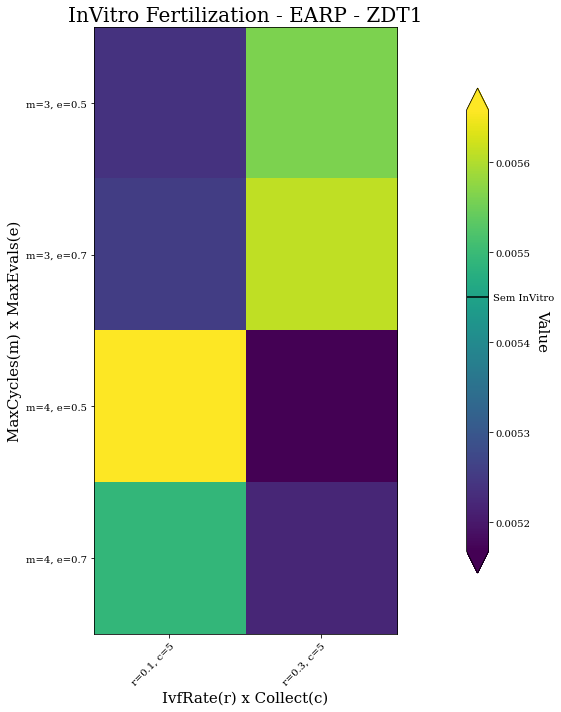

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(linha)

cbar = ax.figure.colorbar(im, ax=ax, pad=0.1,  shrink=0.8, format="%.4f")
cbar.ax.set_ylabel('Value', rotation=-90, va="bottom", size=15)
cbar.ax.axhline(y= s_invitro, c= 'black')
cbar.ax.text(1.2, s_invitro, 'S-IVF',va='center', transform=cbar.ax.get_yaxis_transform())

# Add axis tick labels
ax.set_xticks(np.arange(len(nomesrc)))
ax.set_xticklabels(nomesrc)
ax.set_xlabel("IvfRate(r) x Collect(c)",size=15)

ax.set_yticks(np.arange(len(nomesme)))
ax.set_yticklabels(nomesme)
ax.set_ylabel("MaxCycles(m) x MaxEvals(e)",size=15)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax.set_title("InVitro Fertilization - EARP - ZDT1", size=20)
fig.tight_layout()
plt.savefig("heatmap_in_matplotlib.png",
                    format='png',dpi=150)

In [ ]:
data = linha
y = ["Book {}".format(i) for i in range(1, 8)]
x = ["Store {}".format(i) for i in list("ABCDEFG")]
im, _ = heatmap(data, y, x, ax=ax2, vmin=0,
                cmap="magma_r", cbarlabel="weekly sold copies")
annotate_heatmap(im, valfmt="{x:d}", size=7, threshold=20,
                 textcolors=("red", "white"))

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data_1 = igd_nsga
data_2 = igd_spea
data = [data_1, data_2]

fig = plt.figure(figsize =(10, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(data, showfliers = False)
ax.set_title('Comparação ZDT4')
plt.xticks([1, 2], ['SPEA2', 'SPEA2_IVF'])
# show plot
plt.show()

#Heat

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

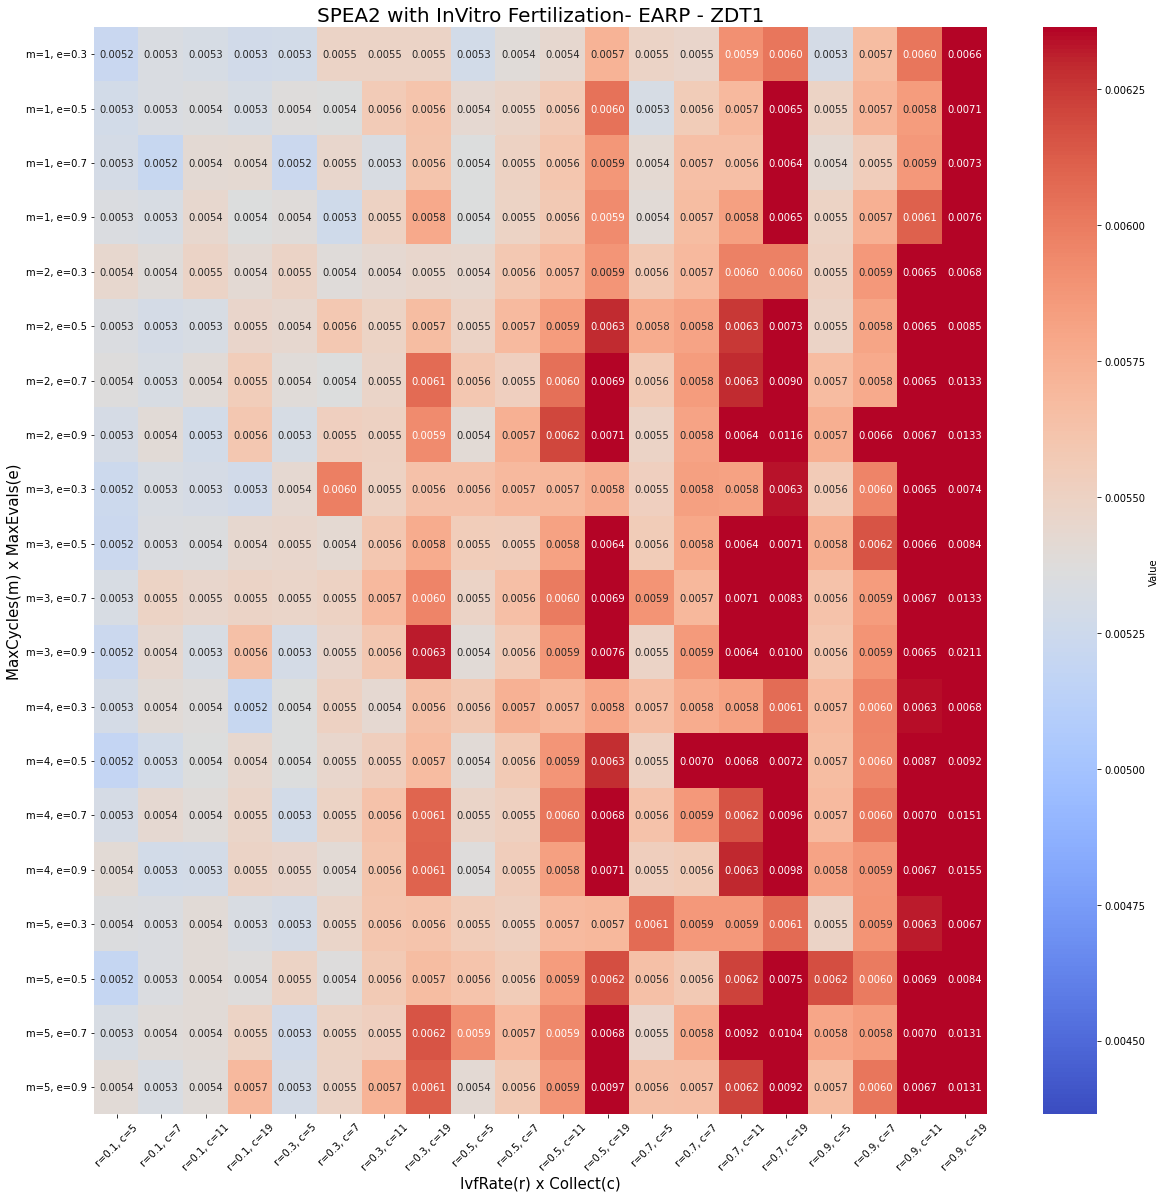

In [ ]:
pf = problem.pareto_front(use_cache=False)

metric = IGD(pf, zero_to_one=True)

s_invitro = []
with open(r'/content/drive/MyDrive/seminvit.txt', 'r') as fp:
    for line in fp:
        # remove linebreak from a current name
        # linebreak is the last character of each line
        x = line[:-1]

        # add current item to the list
        s_invitro.append(float(x))




fig, axi = plt.subplots(figsize=(20,20))
ax = sns.heatmap(tabela, annot=True, vmax = np.mean(s_invitro)+0.001, vmin = np.mean(s_invitro)-0.001 , center = np.mean(s_invitro), cmap="coolwarm", fmt=".4f", xticklabels = tabela.columns, yticklabels = tabela.index, ax = axi,
                 cbar_kws={"label": "Value", "orientation": 'vertical', 'drawedges': False, "spacing":'uniform'})


ax.set_xlabel("IvfRate(r) x Collect(c)", size = 15)
ax.set_ylabel("MaxCycles(m) x MaxEvals(e)", size = 15)
ax.set_title("SPEA2 with InVitro Fertilization- EARP - ZDT1", size=20)

plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.setp(ax.get_yticklabels(), rotation=0, va="center")